In [1]:
import numpy

import constants
import rscha2d
import trig
import fibonacci_sphere
import coords
import gauge

from matplotlib import pyplot

%matplotlib nbagg

In [2]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2000, 2000, 50)

In [3]:
import importlib
importlib.reload(rscha2d)

model_bd = rscha2d.Model()
model_bd.set_model_params(theta_c, phi_c, theta_0d, 0.1, 3, 3, 2, knots=knots_bd,
                          temporal_reg=0, spatial_reg=10, g10_ref=-37)
model_bd.add_data("../data/rscha2d/bd_sha_orig_trim.dat")

In [46]:
l_points = 20
t_ls = numpy.logspace(-6, 6, l_points)
D_rms = numpy.empty(l_points)
I_rms = numpy.empty(l_points)
F_rms = numpy.empty(l_points)

D_nrms = numpy.empty(l_points)
I_nrms = numpy.empty(l_points)
F_nrms = numpy.empty(l_points)

a95 = model_bd.a95.copy()
a95[((~model_bd.nan_I | ~model_bd.nan_D) & numpy.isnan(a95)) |
     (a95 < numpy.deg2rad(4.3))] = numpy.deg2rad(4.3)
F_err = model_bd.F_err.copy()
F_err[(~model_bd.nan_F & numpy.isnan(F_err)) | (F_err < 5.0)] = 5.0

In [47]:
model_bd.spatial_reg = 0

In [48]:
for i, t_lambda in enumerate(t_ls):
    
    model_bd.temporal_reg = t_lambda
    g_bd = model_bd.solve()
    D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
    D_rem_bd = trig.mindiff(D_rem_bd, 0)
    I_rem_bd = trig.mindiff(I_rem_bd, 0)

    
    D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]
    D_nres_bd = D_res_bd / a95[~model_bd.nan_D]
    I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
    I_nres_bd = I_res_bd / a95[~model_bd.nan_I]
    F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]
    F_nres_bd = F_res_bd / F_err[~model_bd.nan_F]
    
    D_rms[i] = numpy.sqrt(numpy.average(D_res_bd**2))
    I_rms[i] = numpy.sqrt(numpy.average(I_res_bd**2))
    F_rms[i] = numpy.sqrt(numpy.average(F_res_bd**2))
    
    D_nrms[i] = numpy.sqrt(numpy.average(D_nres_bd**2))
    I_nrms[i] = numpy.sqrt(numpy.average(I_nres_bd**2))
    F_nrms[i] = numpy.sqrt(numpy.average(F_nres_bd**2))
    
    print(gauge.gauge(i+1, l_points), end="\r")

In [49]:
D_nrms.min()

1.1524749304880511

In [50]:
numpy.isnan(model_bd.F_err[~model_bd.nan_F]).sum()

10

<IPython.core.display.Javascript object>


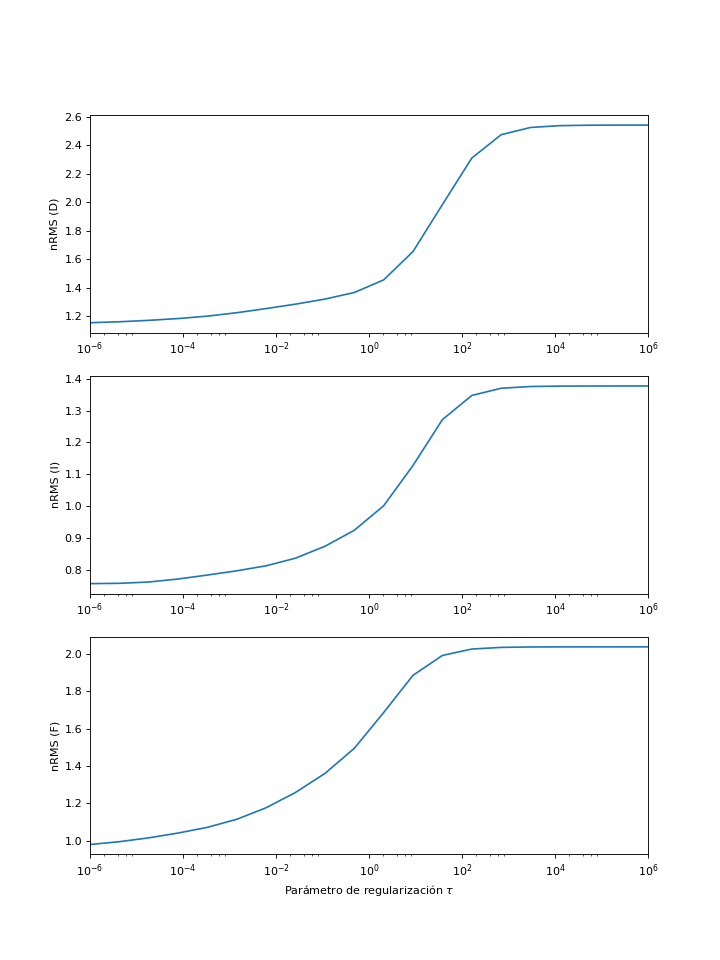

In [51]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(9,12))

ax0.plot(t_ls, D_nrms)
ax1.plot(t_ls, I_nrms)
ax2.plot(t_ls, F_nrms)

ax0.set_ylabel("nRMS (D)")
ax1.set_ylabel("nRMS (I)")
ax2.set_ylabel("nRMS (F)")
ax2.set_xlabel(r"Parámetro de regularización $\tau $")

for ax in (ax0, ax1, ax2):
    ax.set_xscale("log")
    ax.set_xbound(numpy.min(t_ls), numpy.max(t_ls))

let's choose like idk $\tau = 10$?

$\tau = 1$?

In [18]:
model_bd.temporal_reg = 1

In [19]:
s_ls = numpy.logspace(-1, 6, l_points)

for i, s_lambda in enumerate(s_ls):
    
    model_bd.spatial_reg = s_lambda
    g_bd = model_bd.solve()
    D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
    D_rem_bd = trig.mindiff(D_rem_bd, 0)
    I_rem_bd = trig.mindiff(I_rem_bd, 0)

    
    D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]
    D_nres_bd = D_res_bd / a95[~model_bd.nan_D]
    I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
    I_nres_bd = I_res_bd / a95[~model_bd.nan_I]
    F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]
    F_nres_bd = F_res_bd / F_err[~model_bd.nan_F]
    
    D_rms[i] = numpy.sqrt(numpy.average(D_res_bd**2))
    I_rms[i] = numpy.sqrt(numpy.average(I_res_bd**2))
    F_rms[i] = numpy.sqrt(numpy.average(F_res_bd**2))
    
    D_nrms[i] = numpy.sqrt(numpy.average(D_nres_bd**2))
    I_nrms[i] = numpy.sqrt(numpy.average(I_nres_bd**2))
    F_nrms[i] = numpy.sqrt(numpy.average(F_nres_bd**2))
    
    print(gauge.gauge(i+1, l_points), end="\r")

<IPython.core.display.Javascript object>


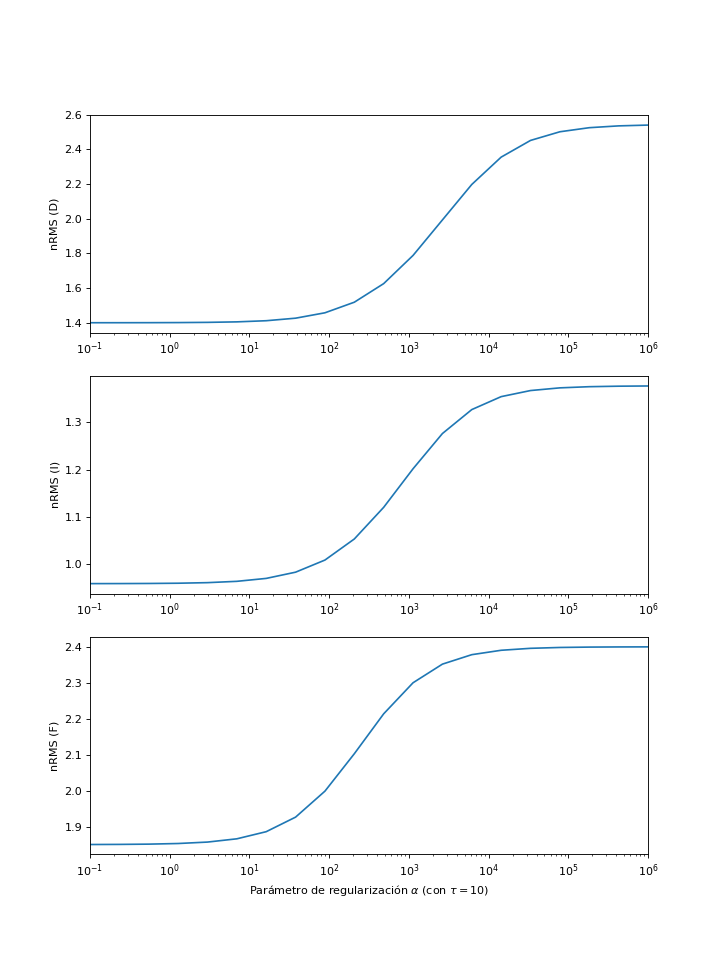

In [20]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(9,12))

ax0.plot(s_ls, D_nrms)
ax1.plot(s_ls, I_nrms)
ax2.plot(s_ls, F_nrms)

ax0.set_ylabel("nRMS (D)")
ax1.set_ylabel("nRMS (I)")
ax2.set_ylabel("nRMS (F)")
ax2.set_xlabel(r"Parámetro de regularización $\alpha $ (con $\tau = 10$)")

for ax in (ax0, ax1, ax2):
    ax.set_xscale("log")
    ax.set_xbound(numpy.min(s_ls), numpy.max(s_ls))

so $\alpha = 1000$ ?

**at this point, go back to the previous notebook and use them god damn**

$\tau = 10 ; \alpha = 1000$ <- esto es excesivo

#### 2D shit

In [56]:
t_lambdas = numpy.logspace(-6, 6, l_points)
s_lambdas = numpy.logspace(-2, 6, l_points)

D_rms = numpy.empty((l_points, l_points))
I_rms = numpy.empty((l_points, l_points))
F_rms = numpy.empty((l_points, l_points))

D_nrms = numpy.empty((l_points, l_points))
I_nrms = numpy.empty((l_points, l_points))
F_nrms = numpy.empty((l_points, l_points))

a95 = model_bd.a95.copy()
a95[((~model_bd.nan_I | ~model_bd.nan_D) & numpy.isnan(a95)) |
     (a95 < numpy.deg2rad(4.3))] = numpy.deg2rad(4.3)
F_err = model_bd.F_err.copy()
F_err[(~model_bd.nan_F & numpy.isnan(F_err)) | (F_err < 5.0)] = 5.0

for i, t_ls in enumerate(t_lambdas):
    model_bd.temporal_reg = t_ls
    for j, s_ls in enumerate(s_lambdas):        
        model_bd.spatial_reg = s_ls
        g_bd = model_bd.solve()
        D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                       model_bd.theta_geo, model_bd.phi_geo, g_bd)
        D_rem_bd = trig.mindiff(D_rem_bd, 0)
        I_rem_bd = trig.mindiff(I_rem_bd, 0)
    
        D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]
        D_nres_bd = D_res_bd / a95[~model_bd.nan_D]
        I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
        I_nres_bd = I_res_bd / a95[~model_bd.nan_I]
        F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]
        F_nres_bd = F_res_bd / F_err[~model_bd.nan_F]
    
        D_rms[i, j] = numpy.sqrt(numpy.average(D_res_bd**2))
        I_rms[i, j] = numpy.sqrt(numpy.average(I_res_bd**2))
        F_rms[i, j] = numpy.sqrt(numpy.average(F_res_bd**2))
    
        D_nrms[i, j] = numpy.sqrt(numpy.average(D_nres_bd**2))
        I_nrms[i, j] = numpy.sqrt(numpy.average(I_nres_bd**2))
        F_nrms[i, j] = numpy.sqrt(numpy.average(F_nres_bd**2))
        
        print(gauge.gauge(i*l_points+(j+1), l_points**2), end="\r")

In [60]:
t_lambdas.shape

(20,)

<IPython.core.display.Javascript object>


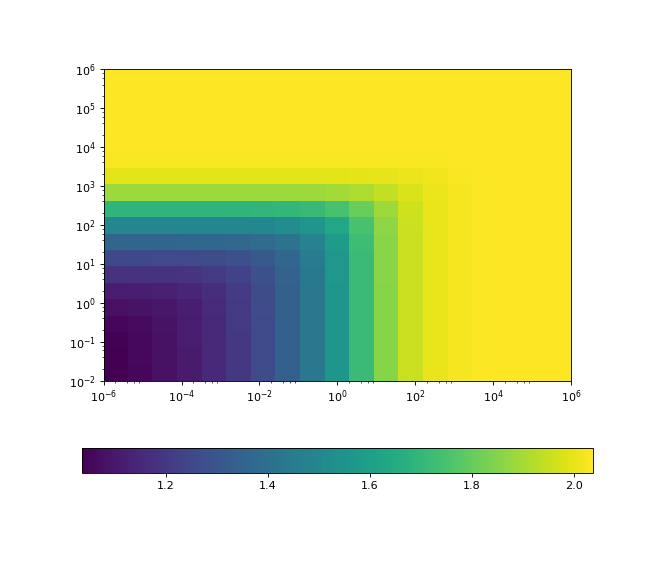

In [71]:
fig, ax = pyplot.subplots(subplot_kw={"aspect":"equal"})

fig.colorbar(ax.pcolormesh(t_lambdas, s_lambdas, F_nrms), orientation="horizontal")
ax.set_yscale('log')
ax.set_xscale('log')

In [62]:
F_nrms

array([[ 1.03625902,  1.05577375,  1.07941338,  1.10998581,  1.14987923,
         1.20024008,  1.26229682,  1.33923792,  1.43701368,  1.56292019,
         1.71428618,  1.85729818,  1.95352748,  2.00238898,  2.02347346,
         2.03193127,  2.03522108,  2.03648269,  2.03696337,  2.037146  ],
       [ 1.03741126,  1.0562786 ,  1.07964626,  1.11009726,  1.14993197,
         1.2002643 ,  1.26230747,  1.33924237,  1.43701547,  1.56292089,
         1.71428644,  1.85729825,  1.9535275 ,  2.00238898,  2.02347346,
         2.03193127,  2.03522108,  2.03648269,  2.03696337,  2.037146  ],
       [ 1.04159279,  1.05829761,  1.08061864,  1.11057003,  1.15015692,
         1.20036782,  1.26235302,  1.33926142,  1.43702309,  1.56292388,
         1.71428753,  1.85729856,  1.95352756,  2.00238899,  2.02347346,
         2.03193127,  2.03522108,  2.03648269,  2.03696337,  2.037146  ],
       [ 1.05313606,  1.06522602,  1.08440678,  1.11251892,  1.15110551,
         1.20080831,  1.26254757,  1.33934289,  